### Import required libraries

In [2]:
import random
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Sequential as Seq, Linear, ReLU

from sklearn.svm import SVC

from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, OrdinalEncoder, Normalizer

In [3]:
!pip install torch_geometric
tv = torch.__version__
!pip install torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-{tv}.html

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 19.3 MB/s eta 0:00:0000:01
Looking in links: https://data.pyg.org/whl/torch-2.1.2.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.0/108.0 kB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.0/210.0 kB 11.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for torch_scatter: filename=torch_scatter-2.1.2-cp310-cp310-linux_x86_64.whl size=3764948 sha256=ad16e050ba4af25d61d93562c67514d966cc0ac7bb73e5f8ae538bc1336ced3c
  Stored in directory: /root/.cache/pip/wheels/92/f1/2b/3b46d54b134259f58c8363568569053248040859b1a145b3ce
  Created wheel for torch_sparse: filename=torch_sparse-0.6.18-cp310-cp310-linux_x86_64

In [4]:
from torch_geometric.data import Data
from torch_geometric.nn import DynamicEdgeConv, MessagePassing, knn_graph

### Selecting Device

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

### Load traning and test data and Concatinate them

In [6]:
df_train = pd.read_csv('/kaggle/input/ugp1011/trainingData_mod.csv')

In [7]:
missing = 0.0
if missing > 0:
    df_train = df_train.sample(frac=1-missing, random_state=42)

In [8]:
df_val = pd.read_csv('/kaggle/input/ugp1011/validationData_mod.csv')

train_numb = len(df_train)
test_numb = len(df_val)

df = pd.concat([df_train, df_val])
df

,WAP001,WAP002,WAP003,WAP004,WAP005,WAP006,WAP007,WAP008,WAP009,WAP010,...,DRSS520,LONGITUDE,LATITUDE,FLOOR,BUILDINGID,SPACEID,RELATIVEPOSITION,USERID,PHONEID,TIMESTAMP
0,0,0,0,0,0,0,0,0,0,0,...,0.0,-7541.264300,4.864921e+06,2,1,106,2,2,23,1371713733
1,0,0,0,0,0,0,0,0,0,0,...,0.0,-7536.621200,4.864934e+06,2,1,106,2,2,23,1371713691
2,0,0,0,0,0,0,0,7,0,0,...,0.0,-7519.152400,4.864950e+06,2,1,103,2,2,23,1371714095
3,0,0,0,0,0,0,0,0,0,0,...,0.0,-7524.570400,4.864934e+06,2,1,102,2,2,23,1371713807
4,0,0,0,0,0,0,0,0,0,0,...,0.0,-7632.143600,4.864982e+06,0,0,122,2,11,13,1369909710
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1106,0,0,0,0,0,0,0,0,0,0,...,0.0,-7317.344231,4.864796e+06,3,2,0,0,0,13,1381156711
1107,0,0,0,0,0,0,0,0,0,0,...,0.0,-7313.731120,4.864792e+06,3,2,0,0,0,13,1381156730
1108,0,0,0,0,0,0,0,0,0,0,...,0.0,-7637.535798,4.864903e+06,0,0,0,0,0,13,1381247781
1109,0,0,0,0,0,0,0,0,0,0,...,0.0,-7636.654005,4.864905e+06,0,0,0,0,0,13,1381247807


### Create Classes for classification

In [9]:
df['CLASS'] = df['BUILDINGID'].astype(str) + df['FLOOR'].astype(str)
df

,WAP001,WAP002,WAP003,WAP004,WAP005,WAP006,WAP007,WAP008,WAP009,WAP010,...,LONGITUDE,LATITUDE,FLOOR,BUILDINGID,SPACEID,RELATIVEPOSITION,USERID,PHONEID,TIMESTAMP,CLASS
0,0,0,0,0,0,0,0,0,0,0,...,-7541.264300,4.864921e+06,2,1,106,2,2,23,1371713733,12
1,0,0,0,0,0,0,0,0,0,0,...,-7536.621200,4.864934e+06,2,1,106,2,2,23,1371713691,12
2,0,0,0,0,0,0,0,7,0,0,...,-7519.152400,4.864950e+06,2,1,103,2,2,23,1371714095,12
3,0,0,0,0,0,0,0,0,0,0,...,-7524.570400,4.864934e+06,2,1,102,2,2,23,1371713807,12
4,0,0,0,0,0,0,0,0,0,0,...,-7632.143600,4.864982e+06,0,0,122,2,11,13,1369909710,00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1106,0,0,0,0,0,0,0,0,0,0,...,-7317.344231,4.864796e+06,3,2,0,0,0,13,1381156711,23
1107,0,0,0,0,0,0,0,0,0,0,...,-7313.731120,4.864792e+06,3,2,0,0,0,13,1381156730,23
1108,0,0,0,0,0,0,0,0,0,0,...,-7637.535798,4.864903e+06,0,0,0,0,0,13,1381247781,00
1109,0,0,0,0,0,0,0,0,0,0,...,-7636.654005,4.864905e+06,0,0,0,0,0,13,1381247807,00


In [10]:
no_out = len(df['CLASS'].unique())
no_out

13

In [11]:
df_y = df[["CLASS"]]
df_y

,CLASS
0,12
1,12
2,12
3,12
4,00
...,...
1106,23
1107,23
1108,00
1109,00


In [12]:
enc = OrdinalEncoder(dtype=np.int32)
y = enc.fit_transform(df_y['CLASS'].values.reshape(-1,1))
y = y.reshape(-1,)

In [13]:
y.max()

12

In [14]:
y

array([6, 6, 6, ..., 0, 0, 0], dtype=int32)

### Seperate Input and Output

In [15]:
df_x = df.iloc[: , :1040]

df_x

,WAP001,WAP002,WAP003,WAP004,WAP005,WAP006,WAP007,WAP008,WAP009,WAP010,...,DRSS511,DRSS512,DRSS513,DRSS514,DRSS515,DRSS516,DRSS517,DRSS518,DRSS519,DRSS520
0,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,0,0,0,0,0,0,7,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1106,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1107,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1108,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1109,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
# Split data into train and test sets
X_train = df_x
X_test = df_x[len(df_train):]
y_train = y
y_test = y[len(df_train):]

### Scale the input features

In [17]:
norm_scl = Normalizer()

norm_scl.fit(X_train)

Normalizer()

In [18]:
df_x = norm_scl.transform(df_x)

In [19]:
X_train = norm_scl.transform(X_train)
X_test = norm_scl.transform(X_test)

In [20]:
print("Normalized X_train:")
print(X_train[0])

Normalized X_train:
[0. 0. 0. ... 0. 0. 0.]


### Define node Feature and Lable & Create Data object

In [21]:
# Define the node features
x = torch.tensor(df_x, dtype=torch.float).float()

# Define the node labels
y = torch.tensor(y, dtype=torch.float).long().reshape(-1)

# Create the Data object
data = Data(x=x, y=y)
data = data.to(device)

### Define Train and Test Mask

In [22]:
# train_mask = np.array([random.random() < 0.8 for _ in data.x])
train_mask = torch.BoolTensor([True]*(train_numb) + [False]*test_numb).view(-1)
train_mask

tensor([ True,  True,  True,  ..., False, False, False])

In [23]:
test_mask = np.invert(train_mask)
test_mask

tensor([0, 0, 0,  ..., 1, 1, 1], dtype=torch.uint8)

In [24]:
data.train_mask = torch.tensor(train_mask, dtype=torch.bool)
data.test_mask = torch.tensor(test_mask, dtype=torch.bool)

/tmp/ipykernel_34/950961007.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data.train_mask = torch.tensor(train_mask, dtype=torch.bool)
/tmp/ipykernel_34/950961007.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data.test_mask = torch.tensor(test_mask, dtype=torch.bool)


### Print some quick statistics about the data:

In [25]:
# number of nodes
print("Number of nodes: ", data.num_nodes)

Number of nodes:  21048


In [26]:
# sample nodes from the graph
print("Shape of sample nodes: ", data.x.shape)

Shape of sample nodes:  torch.Size([21048, 1040])


In [27]:
# check training nodes
print("# of nodes to train on: ", data.train_mask.sum().item())

# check test nodes
print("# of nodes to test on: ", data.test_mask.sum().item())

# of nodes to train on:  19937
# of nodes to test on:  1111


In [28]:
print("X shape: ", data.x.shape)
# print("Edge shape: ", data.edge_index.shape)
print("Y shape: ", data.y.shape)

X shape:  torch.Size([21048, 1040])
Y shape:  torch.Size([21048])


### Define DynamicEdgeConv

In [29]:
class EdgeConv(MessagePassing):
    def __init__(self, in_channels, out_channels):
        super().__init__(aggr='sum')
        self.mlp = Seq(Linear(2 * in_channels, out_channels), ReLU(), Linear(out_channels, out_channels))

    def forward(self, x, edge_index):
        return self.propagate(edge_index, x=x)

    def message(self, x_i, x_j):
        tmp = torch.cat([x_i, x_j - x_i], dim=1)  # tmp has shape [E, 2 * in_channels]
        return self.mlp(tmp)

In [30]:
class DynamicEdgeConv(EdgeConv):
    def __init__(self, in_channels, out_channels, k=5):
        super().__init__(in_channels, out_channels)
        self.k = k

    def forward(self, x, batch=None):
        edge_index = knn_graph(x, self.k, batch, loop=False, flow=self.flow)
        return super().forward(x, edge_index)

### Define Model

In [31]:
class DEC(torch.nn.Module):
    def __init__(self, k1, k2):
        super().__init__()
        self.conv1 = DynamicEdgeConv(data.num_features, 256, k=k1)
        self.conv2 = DynamicEdgeConv(256, 50, k=k2)
        self.fc1 = nn.Linear(50, no_out)
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, data):
        x = data.x
        x = self.conv1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc1(x)

        return x

In [32]:
# useful function for computing accuracy
def compute_accuracy(pred_y, y):
    return (pred_y == y).sum()

In [33]:
data.y

tensor([6, 6, 6,  ..., 0, 0, 0], device='cuda:0')

In [1]:
total_accuracies = []
total_losses = []

### Train the model

In [34]:
def train_fun(k1, k2, lr):
    model = DEC(k1, k2).to(device)
    print("model uploaded")
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=5e-4)
    loss_function = nn.CrossEntropyLoss()
    
    losses = []
    accuracies = []
    test_accu = []

    # epoch = 0
    for epoch in range(25):
        model.train()
        optimizer.zero_grad()
        out = model(data)
        loss = loss_function(out[data.train_mask], data.y[data.train_mask])
        correct = compute_accuracy(out.argmax(dim=1)[data.train_mask], data.y[data.train_mask])
        acc = int(correct) / int(data.train_mask.sum())
        losses.append(loss.item())
        accuracies.append(acc)


        loss.backward()
        optimizer.step()

        # epoch+=1

        if (epoch) % 1 == 0:
            model.eval()
            pred = model(data).argmax(dim=1)
            correct = compute_accuracy(pred[data.test_mask], data.y[data.test_mask])
            acc_test = int(correct) / int(data.test_mask.sum())
            test_accu.append(acc_test)
            print(f'Epoch: {epoch}, \tAccuracy: {acc}, \tTest accuracy: {acc_test}')
          
    res = f"best performance on train: {max(accuracies)}, test: {max(test_accu)}"  
    print(res)
    #plt.plot(accuracies)
    total_accuracies.append(test_accu)
    plt.plot(test_accu)
    #plt.title(Accuracy)
    #plt.legend(['RSSI acc.', 'DRSS acc.'])
   #plt.savefig('with DRSS.png')
    plt.locator_params(axis='x', nbins=5)  # Adjust the number of ticks on the x-axis
    plt.locator_params(axis='y', nbins=10)  # Adjust the number of ticks on the y-axis
    plt.show()

In [35]:
#train_fun(15, 10, 0.009)

### Grid Search with varying k1 and k2

Doing for:  30 15
model uploaded
Epoch: 0, 	Accuracy: 0.08010232231529317, 	Test accuracy: 0.0999099909990999
Epoch: 1, 	Accuracy: 0.09846014947083312, 	Test accuracy: 0.0747074707470747
Epoch: 2, 	Accuracy: 0.10026583738777148, 	Test accuracy: 0.12061206120612061
Epoch: 3, 	Accuracy: 0.1173195566033004, 	Test accuracy: 0.16111611161116113
Epoch: 4, 	Accuracy: 0.16782866027988164, 	Test accuracy: 0.3213321332133213
Epoch: 5, 	Accuracy: 0.22566083161960174, 	Test accuracy: 0.43114311431143115
Epoch: 6, 	Accuracy: 0.2568089481867884, 	Test accuracy: 0.43474347434743477
Epoch: 7, 	Accuracy: 0.33676079650900337, 	Test accuracy: 0.5022502250225023
Epoch: 8, 	Accuracy: 0.3771881426493454, 	Test accuracy: 0.5661566156615662
Epoch: 9, 	Accuracy: 0.4247880824597482, 	Test accuracy: 0.6003600360036003
Epoch: 10, 	Accuracy: 0.48297135978331746, 	Test accuracy: 0.7218721872187218
Epoch: 11, 	Accuracy: 0.5280633997090836, 	Test accuracy: 0.7047704770477048
Epoch: 12, 	Accuracy: 0.5912123188042333, 

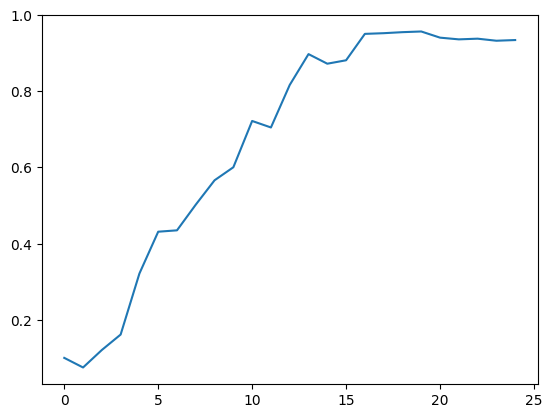

Doing for:  30 10
model uploaded
Epoch: 0, 	Accuracy: 0.08391433013994082, 	Test accuracy: 0.07650765076507651
Epoch: 1, 	Accuracy: 0.08050358629683503, 	Test accuracy: 0.06030603060306031
Epoch: 2, 	Accuracy: 0.10563274314089381, 	Test accuracy: 0.08280828082808281
Epoch: 3, 	Accuracy: 0.20384210262326327, 	Test accuracy: 0.07200720072007201
Epoch: 4, 	Accuracy: 0.2540001003159954, 	Test accuracy: 0.1116111611161116
Epoch: 5, 	Accuracy: 0.2780759392085068, 	Test accuracy: 0.1701170117011701
Epoch: 6, 	Accuracy: 0.3224657671665747, 	Test accuracy: 0.3483348334833483
Epoch: 7, 	Accuracy: 0.3743792947785524, 	Test accuracy: 0.45364536453645365
Epoch: 8, 	Accuracy: 0.4062797813111301, 	Test accuracy: 0.5031503150315032
Epoch: 9, 	Accuracy: 0.44374780558760096, 	Test accuracy: 0.6264626462646264
Epoch: 10, 	Accuracy: 0.5118623664543311, 	Test accuracy: 0.7578757875787578
Epoch: 11, 	Accuracy: 0.5779204494156593, 	Test accuracy: 0.7983798379837984
Epoch: 12, 	Accuracy: 0.6305863469930281, 	

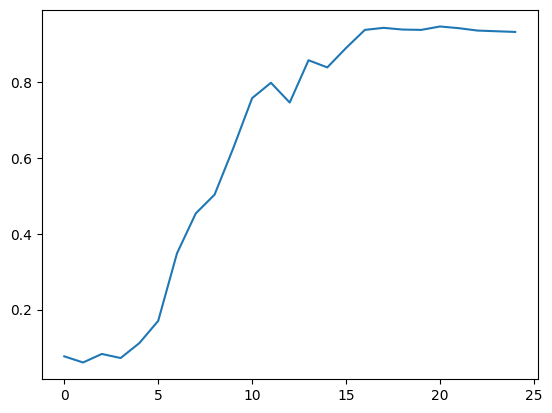

Doing for:  30 6
model uploaded
Epoch: 0, 	Accuracy: 0.09329387570848172, 	Test accuracy: 0.09900990099009901
Epoch: 1, 	Accuracy: 0.08802728595074484, 	Test accuracy: 0.021602160216021602
Epoch: 2, 	Accuracy: 0.12343883232181371, 	Test accuracy: 0.2826282628262826
Epoch: 3, 	Accuracy: 0.22576114761498722, 	Test accuracy: 0.13861386138613863
Epoch: 4, 	Accuracy: 0.27411345739078097, 	Test accuracy: 0.35553555355535554
Epoch: 5, 	Accuracy: 0.3576265235491799, 	Test accuracy: 0.3438343834383438
Epoch: 6, 	Accuracy: 0.42443697647589906, 	Test accuracy: 0.5355535553555355
Epoch: 7, 	Accuracy: 0.4865325776195014, 	Test accuracy: 0.5346534653465347
Epoch: 8, 	Accuracy: 0.5518382906154387, 	Test accuracy: 0.6714671467146714
Epoch: 9, 	Accuracy: 0.6123288358328736, 	Test accuracy: 0.6624662466246625
Epoch: 10, 	Accuracy: 0.6708130611425992, 	Test accuracy: 0.738973897389739
Epoch: 11, 	Accuracy: 0.7221246927822641, 	Test accuracy: 0.8514851485148515
Epoch: 12, 	Accuracy: 0.7630536188995335, 	T

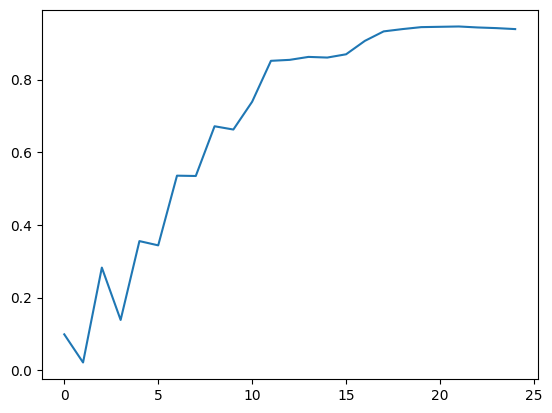

Doing for:  30 3
model uploaded
Epoch: 0, 	Accuracy: 0.07438431057832172, 	Test accuracy: 0.0999099909990999
Epoch: 1, 	Accuracy: 0.12399057029643376, 	Test accuracy: 0.036003600360036005
Epoch: 2, 	Accuracy: 0.16958419019912724, 	Test accuracy: 0.11251125112511251
Epoch: 3, 	Accuracy: 0.21532828409489893, 	Test accuracy: 0.34743474347434744
Epoch: 4, 	Accuracy: 0.31785123137884336, 	Test accuracy: 0.5931593159315932
Epoch: 5, 	Accuracy: 0.4167628028289111, 	Test accuracy: 0.6687668766876688
Epoch: 6, 	Accuracy: 0.5039374028188794, 	Test accuracy: 0.6831683168316832
Epoch: 7, 	Accuracy: 0.579124241360285, 	Test accuracy: 0.7983798379837984
Epoch: 8, 	Accuracy: 0.6556653458393941, 	Test accuracy: 0.9153915391539154
Epoch: 9, 	Accuracy: 0.7230776947384261, 	Test accuracy: 0.9477947794779478
Epoch: 10, 	Accuracy: 0.799668957215228, 	Test accuracy: 0.9513951395139514
Epoch: 11, 	Accuracy: 0.8508802728595074, 	Test accuracy: 0.9450945094509451
Epoch: 12, 	Accuracy: 0.8789185935697447, 	Test

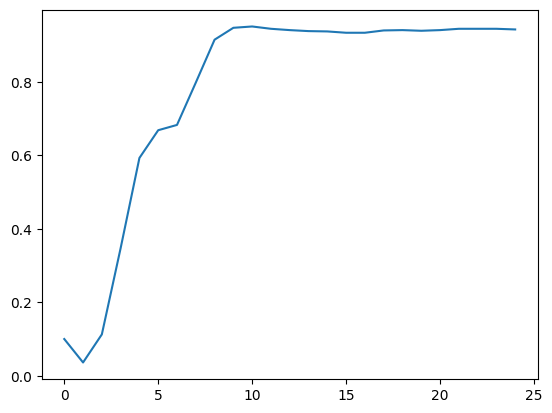

Doing for:  30 1
model uploaded
Epoch: 0, 	Accuracy: 0.055976325425089034, 	Test accuracy: 0.021602160216021602
Epoch: 1, 	Accuracy: 0.09479861563926369, 	Test accuracy: 0.041404140414041404
Epoch: 2, 	Accuracy: 0.16346491448061393, 	Test accuracy: 0.1629162916291629
Epoch: 3, 	Accuracy: 0.2557054722375483, 	Test accuracy: 0.3789378937893789
Epoch: 4, 	Accuracy: 0.3046596779856548, 	Test accuracy: 0.4383438343834383
Epoch: 5, 	Accuracy: 0.35125645784220294, 	Test accuracy: 0.531953195319532
Epoch: 6, 	Accuracy: 0.3913828559963886, 	Test accuracy: 0.5391539153915391
Epoch: 7, 	Accuracy: 0.4732407082309274, 	Test accuracy: 0.6795679567956796
Epoch: 8, 	Accuracy: 0.5247028138636706, 	Test accuracy: 0.6948694869486949
Epoch: 9, 	Accuracy: 0.5722525956763806, 	Test accuracy: 0.7695769576957696
Epoch: 10, 	Accuracy: 0.6495962281185735, 	Test accuracy: 0.7731773177317732
Epoch: 11, 	Accuracy: 0.696694587952049, 	Test accuracy: 0.9027902790279028
Epoch: 12, 	Accuracy: 0.7500125394994231, 	Test

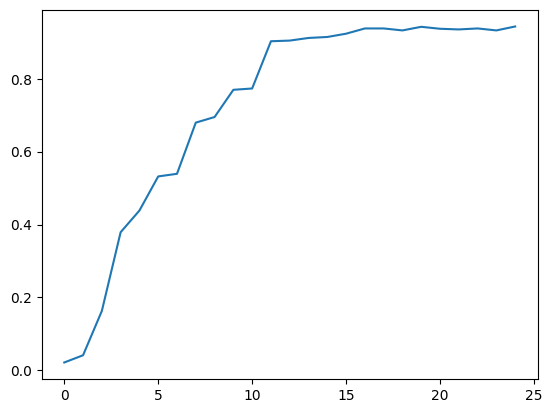

Doing for:  20 15
model uploaded
Epoch: 0, 	Accuracy: 0.06971961679289762, 	Test accuracy: 0.12871287128712872
Epoch: 1, 	Accuracy: 0.08125595626222601, 	Test accuracy: 0.07650765076507651
Epoch: 2, 	Accuracy: 0.09053518583538145, 	Test accuracy: 0.036003600360036005
Epoch: 3, 	Accuracy: 0.11461102472789286, 	Test accuracy: 0.0927092709270927
Epoch: 4, 	Accuracy: 0.1592014846767317, 	Test accuracy: 0.23222322232223222
Epoch: 5, 	Accuracy: 0.2154286000902844, 	Test accuracy: 0.3114311431143114
Epoch: 6, 	Accuracy: 0.2723077694738426, 	Test accuracy: 0.36633663366336633
Epoch: 7, 	Accuracy: 0.332146260721272, 	Test accuracy: 0.40324032403240323
Epoch: 8, 	Accuracy: 0.3937904398856398, 	Test accuracy: 0.5823582358235824
Epoch: 9, 	Accuracy: 0.44354717359683, 	Test accuracy: 0.49324932493249324
Epoch: 10, 	Accuracy: 0.48858905552490345, 	Test accuracy: 0.6426642664266426
Epoch: 11, 	Accuracy: 0.5489291267492602, 	Test accuracy: 0.5256525652565257
Epoch: 12, 	Accuracy: 0.5855946230626473, 	

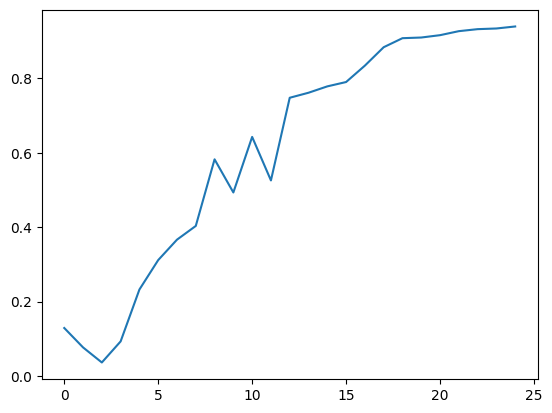

Doing for:  20 10
model uploaded
Epoch: 0, 	Accuracy: 0.09299292772232533, 	Test accuracy: 0.037803780378037805
Epoch: 1, 	Accuracy: 0.11240407282941264, 	Test accuracy: 0.14491449144914492
Epoch: 2, 	Accuracy: 0.13773386166424237, 	Test accuracy: 0.24032403240324032
Epoch: 3, 	Accuracy: 0.15553995084516226, 	Test accuracy: 0.2727272727272727
Epoch: 4, 	Accuracy: 0.19782314290013542, 	Test accuracy: 0.30423042304230424
Epoch: 5, 	Accuracy: 0.22425640768420524, 	Test accuracy: 0.36543654365436545
Epoch: 6, 	Accuracy: 0.26859607764458043, 	Test accuracy: 0.540954095409541
Epoch: 7, 	Accuracy: 0.3557205196368561, 	Test accuracy: 0.6957695769576958
Epoch: 8, 	Accuracy: 0.45001755529919246, 	Test accuracy: 0.7497749774977498
Epoch: 9, 	Accuracy: 0.5268094497667654, 	Test accuracy: 0.8163816381638164
Epoch: 10, 	Accuracy: 0.6029492902643326, 	Test accuracy: 0.8496849684968497
Epoch: 11, 	Accuracy: 0.6688067412348899, 	Test accuracy: 0.8964896489648965
Epoch: 12, 	Accuracy: 0.7182625269599238

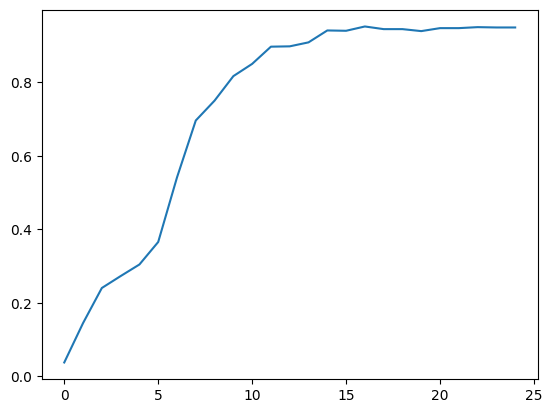

Doing for:  20 6
model uploaded
Epoch: 0, 	Accuracy: 0.07177609469829964, 	Test accuracy: 0.0279027902790279
Epoch: 1, 	Accuracy: 0.10021567939007875, 	Test accuracy: 0.23492349234923493
Epoch: 2, 	Accuracy: 0.15508852886592767, 	Test accuracy: 0.13591359135913592
Epoch: 3, 	Accuracy: 0.2001304107940011, 	Test accuracy: 0.42934293429342935
Epoch: 4, 	Accuracy: 0.31955660330039626, 	Test accuracy: 0.36723672367236726
Epoch: 5, 	Accuracy: 0.38596579224557354, 	Test accuracy: 0.6408640864086409
Epoch: 6, 	Accuracy: 0.46230626473391184, 	Test accuracy: 0.6741674167416741
Epoch: 7, 	Accuracy: 0.5370918392937754, 	Test accuracy: 0.6750675067506751
Epoch: 8, 	Accuracy: 0.6142348397451973, 	Test accuracy: 0.8145814581458146
Epoch: 9, 	Accuracy: 0.6778853388172744, 	Test accuracy: 0.8037803780378038
Epoch: 10, 	Accuracy: 0.7317550283392686, 	Test accuracy: 0.9108910891089109
Epoch: 11, 	Accuracy: 0.7824647640066209, 	Test accuracy: 0.918091809180918
Epoch: 12, 	Accuracy: 0.817274414405377, 	Tes

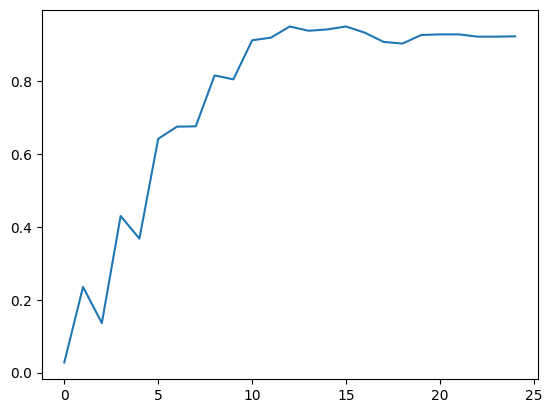

Doing for:  20 3
model uploaded
Epoch: 0, 	Accuracy: 0.07282941264984702, 	Test accuracy: 0.1035103510351035
Epoch: 1, 	Accuracy: 0.11240407282941264, 	Test accuracy: 0.19801980198019803
Epoch: 2, 	Accuracy: 0.2166825500326027, 	Test accuracy: 0.10261026102610261
Epoch: 3, 	Accuracy: 0.2811857350654562, 	Test accuracy: 0.3132313231323132
Epoch: 4, 	Accuracy: 0.37232281687315044, 	Test accuracy: 0.5958595859585959
Epoch: 5, 	Accuracy: 0.4712845463209109, 	Test accuracy: 0.765976597659766
Epoch: 6, 	Accuracy: 0.5132166323920349, 	Test accuracy: 0.7803780378037803
Epoch: 7, 	Accuracy: 0.6230124893414255, 	Test accuracy: 0.8064806480648065
Epoch: 8, 	Accuracy: 0.6870140943973516, 	Test accuracy: 0.8667866786678667
Epoch: 9, 	Accuracy: 0.749109695540954, 	Test accuracy: 0.9144914491449145
Epoch: 10, 	Accuracy: 0.804333651000652, 	Test accuracy: 0.9234923492349235
Epoch: 11, 	Accuracy: 0.8514821688318203, 	Test accuracy: 0.9486948694869487
Epoch: 12, 	Accuracy: 0.8895019310829112, 	Test accu

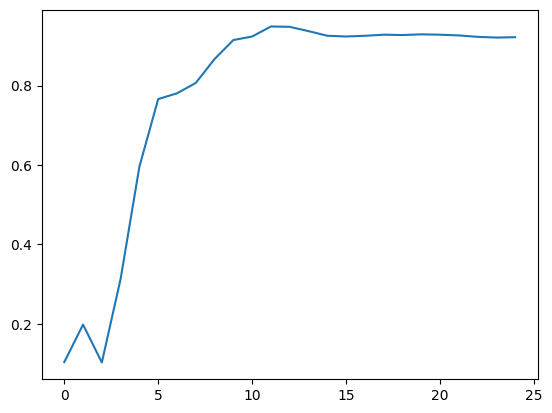

Doing for:  20 1
model uploaded
Epoch: 0, 	Accuracy: 0.09630335557004564, 	Test accuracy: 0.036003600360036005
Epoch: 1, 	Accuracy: 0.12985905602648343, 	Test accuracy: 0.043204320432043204
Epoch: 2, 	Accuracy: 0.16687565832371973, 	Test accuracy: 0.31863186318631864
Epoch: 3, 	Accuracy: 0.21959171389878115, 	Test accuracy: 0.387038703870387
Epoch: 4, 	Accuracy: 0.295831870391734, 	Test accuracy: 0.5031503150315032
Epoch: 5, 	Accuracy: 0.3871194261925064, 	Test accuracy: 0.48514851485148514
Epoch: 6, 	Accuracy: 0.45097055725535434, 	Test accuracy: 0.7245724572457246
Epoch: 7, 	Accuracy: 0.5390981592014846, 	Test accuracy: 0.8370837083708371
Epoch: 8, 	Accuracy: 0.6199026934844761, 	Test accuracy: 0.8406840684068407
Epoch: 9, 	Accuracy: 0.6807945026834529, 	Test accuracy: 0.8343834383438344
Epoch: 10, 	Accuracy: 0.7394292019862567, 	Test accuracy: 0.8397839783978398
Epoch: 11, 	Accuracy: 0.7834679239604755, 	Test accuracy: 0.8577857785778578
Epoch: 12, 	Accuracy: 0.8248984300546722, 	Te

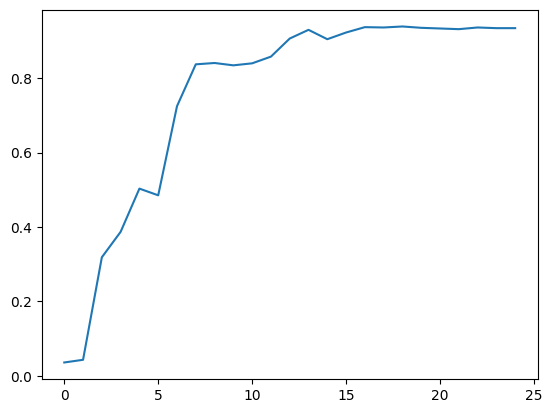

Doing for:  15 10
model uploaded
Epoch: 0, 	Accuracy: 0.0626473391182224, 	Test accuracy: 0.1485148514851485
Epoch: 1, 	Accuracy: 0.09464814164618549, 	Test accuracy: 0.07200720072007201
Epoch: 2, 	Accuracy: 0.17941515774690275, 	Test accuracy: 0.081008100810081
Epoch: 3, 	Accuracy: 0.21768570998645734, 	Test accuracy: 0.10081008100810081
Epoch: 4, 	Accuracy: 0.26643928374379294, 	Test accuracy: 0.23492349234923493
Epoch: 5, 	Accuracy: 0.32050960525655814, 	Test accuracy: 0.40504050405040504
Epoch: 6, 	Accuracy: 0.38501279028941165, 	Test accuracy: 0.5652565256525652
Epoch: 7, 	Accuracy: 0.4532276671515273, 	Test accuracy: 0.6075607560756076
Epoch: 8, 	Accuracy: 0.5197873300897828, 	Test accuracy: 0.738973897389739
Epoch: 9, 	Accuracy: 0.6014947083312434, 	Test accuracy: 0.891989198919892
Epoch: 10, 	Accuracy: 0.6904749962381501, 	Test accuracy: 0.9000900090009001
Epoch: 11, 	Accuracy: 0.748909063550183, 	Test accuracy: 0.9063906390639064
Epoch: 12, 	Accuracy: 0.7965591613582785, 	Test

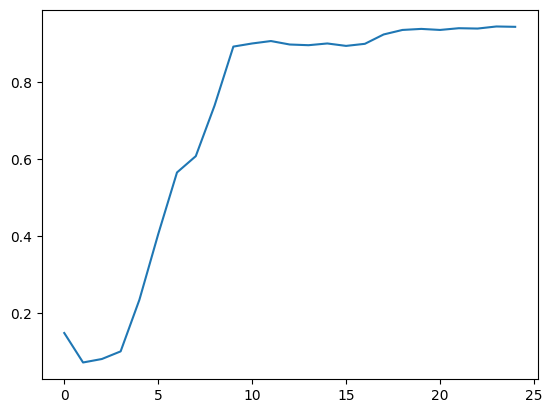

Doing for:  15 6
model uploaded
Epoch: 0, 	Accuracy: 0.0693685108090485, 	Test accuracy: 0.13681368136813682
Epoch: 1, 	Accuracy: 0.12062998445102072, 	Test accuracy: 0.036003600360036005
Epoch: 2, 	Accuracy: 0.15057430907358177, 	Test accuracy: 0.036003600360036005
Epoch: 3, 	Accuracy: 0.21146611827255857, 	Test accuracy: 0.6003600360036003
Epoch: 4, 	Accuracy: 0.32582635301198776, 	Test accuracy: 0.495949594959496
Epoch: 5, 	Accuracy: 0.41064352711039775, 	Test accuracy: 0.5481548154815482
Epoch: 6, 	Accuracy: 0.4949591212318804, 	Test accuracy: 0.7614761476147615
Epoch: 7, 	Accuracy: 0.5824848272056979, 	Test accuracy: 0.7470747074707471
Epoch: 8, 	Accuracy: 0.6506495460701209, 	Test accuracy: 0.8298829882988299
Epoch: 9, 	Accuracy: 0.6985002758689873, 	Test accuracy: 0.8631863186318632
Epoch: 10, 	Accuracy: 0.747604955610172, 	Test accuracy: 0.8460846084608461
Epoch: 11, 	Accuracy: 0.7898881476651453, 	Test accuracy: 0.8586858685868587
Epoch: 12, 	Accuracy: 0.8188794703315444, 	Tes

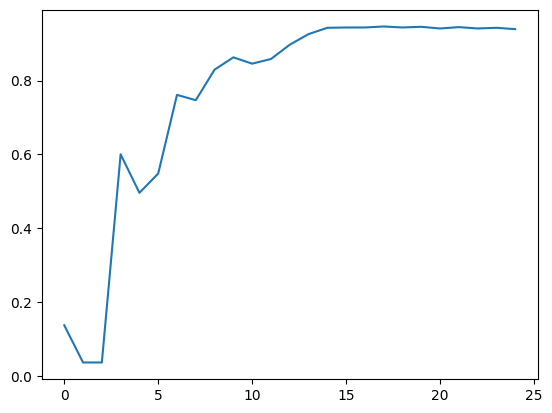

Doing for:  15 3
model uploaded
Epoch: 0, 	Accuracy: 0.06074133520589858, 	Test accuracy: 0.021602160216021602
Epoch: 1, 	Accuracy: 0.09274213773386167, 	Test accuracy: 0.07920792079207921
Epoch: 2, 	Accuracy: 0.17936499974921002, 	Test accuracy: 0.1467146714671467
Epoch: 3, 	Accuracy: 0.19521492702011337, 	Test accuracy: 0.2304230423042304
Epoch: 4, 	Accuracy: 0.2766715152731103, 	Test accuracy: 0.4608460846084608
Epoch: 5, 	Accuracy: 0.3754326127300998, 	Test accuracy: 0.5418541854185418
Epoch: 6, 	Accuracy: 0.4536289311330692, 	Test accuracy: 0.7074707470747075
Epoch: 7, 	Accuracy: 0.5677885338817275, 	Test accuracy: 0.8253825382538253
Epoch: 8, 	Accuracy: 0.6408185785223454, 	Test accuracy: 0.8883888388838884
Epoch: 9, 	Accuracy: 0.7136479911721924, 	Test accuracy: 0.9117911791179117
Epoch: 10, 	Accuracy: 0.7780007022119677, 	Test accuracy: 0.8964896489648965
Epoch: 11, 	Accuracy: 0.8406981993278828, 	Test accuracy: 0.9000900090009001
Epoch: 12, 	Accuracy: 0.8711441039273712, 	Test

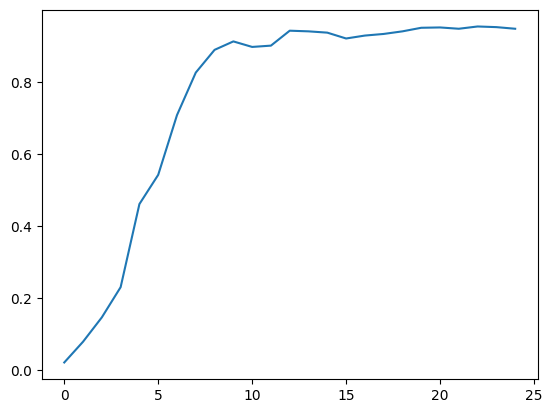

Doing for:  15 1
model uploaded
Epoch: 0, 	Accuracy: 0.06696092691979737, 	Test accuracy: 0.0999099909990999
Epoch: 1, 	Accuracy: 0.10999648894016151, 	Test accuracy: 0.0999099909990999
Epoch: 2, 	Accuracy: 0.13587801574961128, 	Test accuracy: 0.10531053105310531
Epoch: 3, 	Accuracy: 0.23213121332196418, 	Test accuracy: 0.2304230423042304
Epoch: 4, 	Accuracy: 0.3161960174549832, 	Test accuracy: 0.27182718271827183
Epoch: 5, 	Accuracy: 0.3795455685409038, 	Test accuracy: 0.27362736273627364
Epoch: 6, 	Accuracy: 0.43005467221748506, 	Test accuracy: 0.38163816381638166
Epoch: 7, 	Accuracy: 0.4088378391934594, 	Test accuracy: 0.6246624662466247
Epoch: 8, 	Accuracy: 0.5514370266338968, 	Test accuracy: 0.6822682268226823
Epoch: 9, 	Accuracy: 0.5662837939509455, 	Test accuracy: 0.7992799279927992
Epoch: 10, 	Accuracy: 0.6510508100516628, 	Test accuracy: 0.8631863186318632
Epoch: 11, 	Accuracy: 0.7051712895621207, 	Test accuracy: 0.8721872187218722
Epoch: 12, 	Accuracy: 0.7464513216632392, 	Te

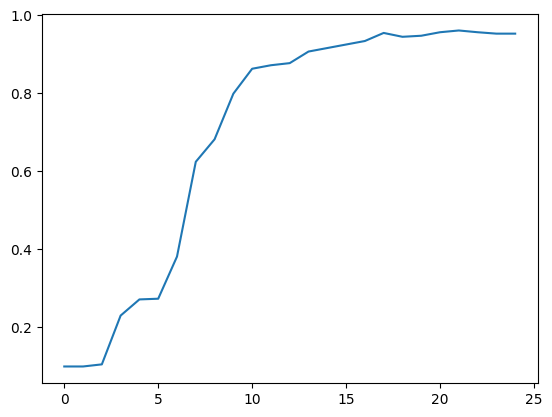

Doing for:  10 6
model uploaded
Epoch: 0, 	Accuracy: 0.08812760194613031, 	Test accuracy: 0.036003600360036005
Epoch: 1, 	Accuracy: 0.1270000501579977, 	Test accuracy: 0.0594059405940594
Epoch: 2, 	Accuracy: 0.21828760595877011, 	Test accuracy: 0.31863186318631864
Epoch: 3, 	Accuracy: 0.285900586848573, 	Test accuracy: 0.3609360936093609
Epoch: 4, 	Accuracy: 0.31915533931885437, 	Test accuracy: 0.37443744374437443
Epoch: 5, 	Accuracy: 0.4000100315995386, 	Test accuracy: 0.576957695769577
Epoch: 6, 	Accuracy: 0.4838240457440939, 	Test accuracy: 0.5778577857785778
Epoch: 7, 	Accuracy: 0.552339870592366, 	Test accuracy: 0.6768676867686768
Epoch: 8, 	Accuracy: 0.6107739379043988, 	Test accuracy: 0.873087308730873
Epoch: 9, 	Accuracy: 0.695942217986658, 	Test accuracy: 0.8955895589558955
Epoch: 10, 	Accuracy: 0.7541756533079199, 	Test accuracy: 0.90999099909991
Epoch: 11, 	Accuracy: 0.7985153232682951, 	Test accuracy: 0.9243924392439244
Epoch: 12, 	Accuracy: 0.8470181070371671, 	Test accura

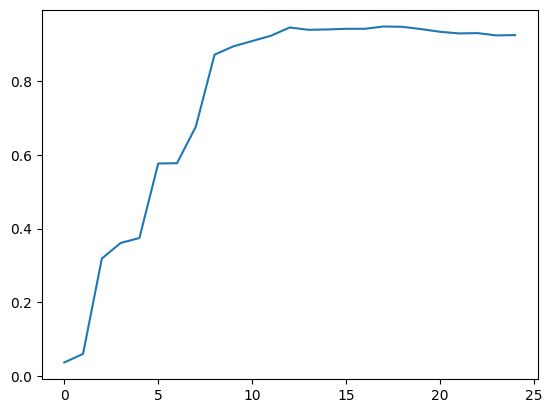

Doing for:  10 3
model uploaded
Epoch: 0, 	Accuracy: 0.07729347444450017, 	Test accuracy: 0.0999099909990999
Epoch: 1, 	Accuracy: 0.1184230325525405, 	Test accuracy: 0.1332133213321332
Epoch: 2, 	Accuracy: 0.18533380147464512, 	Test accuracy: 0.0999099909990999
Epoch: 3, 	Accuracy: 0.2546521542860009, 	Test accuracy: 0.22142214221422143
Epoch: 4, 	Accuracy: 0.3378141144605507, 	Test accuracy: 0.49504950495049505
Epoch: 5, 	Accuracy: 0.41580980087274916, 	Test accuracy: 0.5796579657965797
Epoch: 6, 	Accuracy: 0.4905953754326127, 	Test accuracy: 0.6183618361836184
Epoch: 7, 	Accuracy: 0.5694437478055876, 	Test accuracy: 0.846984698469847
Epoch: 8, 	Accuracy: 0.6710638511310628, 	Test accuracy: 0.9036903690369037
Epoch: 9, 	Accuracy: 0.7353162461754527, 	Test accuracy: 0.9297929792979298
Epoch: 10, 	Accuracy: 0.7991673772383007, 	Test accuracy: 0.9225922592259226
Epoch: 11, 	Accuracy: 0.8399458293624918, 	Test accuracy: 0.9396939693969397
Epoch: 12, 	Accuracy: 0.8741034257912424, 	Test ac

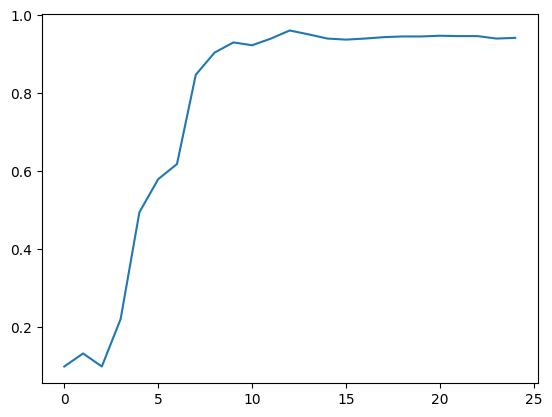

Doing for:  10 1
model uploaded
Epoch: 0, 	Accuracy: 0.0664091889451773, 	Test accuracy: 0.10711071107110712
Epoch: 1, 	Accuracy: 0.12569594221798666, 	Test accuracy: 0.036003600360036005
Epoch: 2, 	Accuracy: 0.14049255153734264, 	Test accuracy: 0.24662466246624662
Epoch: 3, 	Accuracy: 0.17846215579074085, 	Test accuracy: 0.41314131413141314
Epoch: 4, 	Accuracy: 0.2813863670562271, 	Test accuracy: 0.35193519351935193
Epoch: 5, 	Accuracy: 0.3625420073230677, 	Test accuracy: 0.38883888388838883
Epoch: 6, 	Accuracy: 0.41159652906655964, 	Test accuracy: 0.39063906390639064
Epoch: 7, 	Accuracy: 0.47625018809249137, 	Test accuracy: 0.44374437443744374
Epoch: 8, 	Accuracy: 0.5195866980990119, 	Test accuracy: 0.5922592259225923
Epoch: 9, 	Accuracy: 0.5773687114410393, 	Test accuracy: 0.6750675067506751
Epoch: 10, 	Accuracy: 0.6205547474544816, 	Test accuracy: 0.6678667866786678
Epoch: 11, 	Accuracy: 0.6631890454933039, 	Test accuracy: 0.8406840684068407
Epoch: 12, 	Accuracy: 0.7091839293775393

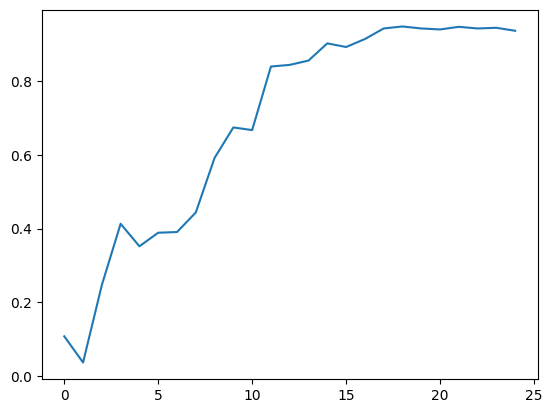

Doing for:  5 3
model uploaded
Epoch: 0, 	Accuracy: 0.07042182876059588, 	Test accuracy: 0.036003600360036005
Epoch: 1, 	Accuracy: 0.13412248583036565, 	Test accuracy: 0.036003600360036005
Epoch: 2, 	Accuracy: 0.16802929227065255, 	Test accuracy: 0.0558055805580558
Epoch: 3, 	Accuracy: 0.23223152931734964, 	Test accuracy: 0.2709270927092709
Epoch: 4, 	Accuracy: 0.30646536590259316, 	Test accuracy: 0.4671467146714671
Epoch: 5, 	Accuracy: 0.36951396900235745, 	Test accuracy: 0.5121512151215122
Epoch: 6, 	Accuracy: 0.44986708130611425, 	Test accuracy: 0.48334833483348333
Epoch: 7, 	Accuracy: 0.5200882780759392, 	Test accuracy: 0.5931593159315932
Epoch: 8, 	Accuracy: 0.5630235241009179, 	Test accuracy: 0.6381638163816382
Epoch: 9, 	Accuracy: 0.6342980388222902, 	Test accuracy: 0.8055805580558055
Epoch: 10, 	Accuracy: 0.6763805988864925, 	Test accuracy: 0.8145814581458146
Epoch: 11, 	Accuracy: 0.73526608817776, 	Test accuracy: 0.8307830783078308
Epoch: 12, 	Accuracy: 0.794051261473642, 	Tes

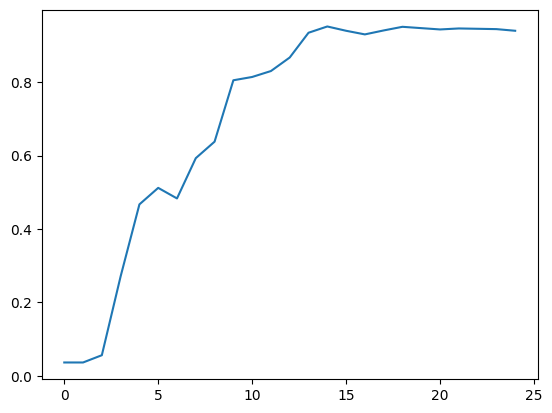

Doing for:  5 1
model uploaded
Epoch: 0, 	Accuracy: 0.08225911621608066, 	Test accuracy: 0.021602160216021602
Epoch: 1, 	Accuracy: 0.11190249285248532, 	Test accuracy: 0.036003600360036005
Epoch: 2, 	Accuracy: 0.1320158499272709, 	Test accuracy: 0.12871287128712872
Epoch: 3, 	Accuracy: 0.13161458594572906, 	Test accuracy: 0.0666066606660666
Epoch: 4, 	Accuracy: 0.18939659928775643, 	Test accuracy: 0.12871287128712872
Epoch: 5, 	Accuracy: 0.22179866579726137, 	Test accuracy: 0.26552655265526554
Epoch: 6, 	Accuracy: 0.25364899433214627, 	Test accuracy: 0.3213321332133213
Epoch: 7, 	Accuracy: 0.32286703114811655, 	Test accuracy: 0.32943294329432943
Epoch: 8, 	Accuracy: 0.37447961077393793, 	Test accuracy: 0.5229522952295229
Epoch: 9, 	Accuracy: 0.41089431709886143, 	Test accuracy: 0.6093609360936093
Epoch: 10, 	Accuracy: 0.4524752971861363, 	Test accuracy: 0.5139513951395139
Epoch: 11, 	Accuracy: 0.5011285549480865, 	Test accuracy: 0.5274527452745275
Epoch: 12, 	Accuracy: 0.53488488739529

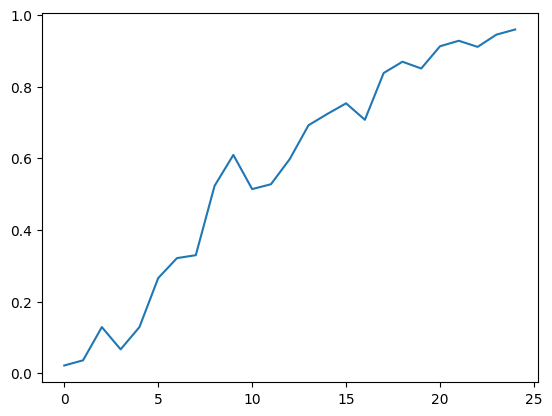

Doing for:  2 1
model uploaded
Epoch: 0, 	Accuracy: 0.08817775994382304, 	Test accuracy: 0.0999099909990999
Epoch: 1, 	Accuracy: 0.1088930129909214, 	Test accuracy: 0.0999099909990999
Epoch: 2, 	Accuracy: 0.13442343381652205, 	Test accuracy: 0.036003600360036005
Epoch: 3, 	Accuracy: 0.14826704117971612, 	Test accuracy: 0.043204320432043204
Epoch: 4, 	Accuracy: 0.15107588905050912, 	Test accuracy: 0.063006300630063
Epoch: 5, 	Accuracy: 0.19486382103626423, 	Test accuracy: 0.15211521152115212
Epoch: 6, 	Accuracy: 0.23313437327581882, 	Test accuracy: 0.1422142214221422
Epoch: 7, 	Accuracy: 0.26874655163765865, 	Test accuracy: 0.11611161116111611
Epoch: 8, 	Accuracy: 0.29327381250940465, 	Test accuracy: 0.21782178217821782
Epoch: 9, 	Accuracy: 0.3390179064051763, 	Test accuracy: 0.35283528352835286
Epoch: 10, 	Accuracy: 0.41064352711039775, 	Test accuracy: 0.38613861386138615
Epoch: 11, 	Accuracy: 0.4871344735918142, 	Test accuracy: 0.44104410441044106
Epoch: 12, 	Accuracy: 0.5443647489592

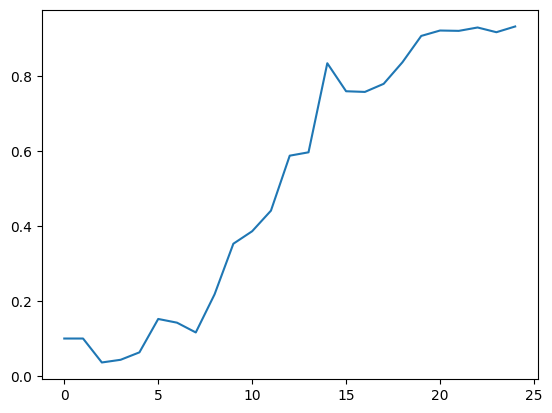

In [36]:
for k1 in [30, 20, 15, 10, 5, 2]:
    for k2 in [15, 10, 6, 3, 1]:
        if k1 > k2:
            print("Doing for: ", k1, k2)
            train_fun(k1, k2, 0.009)